#  Lab Assignment Seven: Sequential Network Architectures

Name 1: Jadon Swearingen (5000)
Name 2: Ephraim Sun (7000)
Name 3: Adeeb Abdul Taher (7000)


In this lab, you will select a prediction task to perform on your dataset, evaluate a sequential architecture and tune hyper-parameters. If any part of the assignment is not clear, ask the instructor to clarify. 

### Dataset Selection

Dataset: https://www.kaggle.com/datasets/rajatkumar30/fake-news

We have chosen a fake news dataset where given the title and text of the article, we should predict if the news is fake or real. 

### Preparation

[1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import nltk, re, string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model # type: ignore
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Flatten, Dropout, Layer, TextVectorization, Dense, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from keras.utils import to_categorical

import itertools

mpl.style.use("seaborn-v0_8-deep")
mpl.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

/var/folders/sd/j5p08m515kd7n9549lkkz_q40000gn/T/ipykernel_8941/2754300558.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer

In [3]:
nltk.download("vader_lexicon")
nltk.download("punkt")
nltk.download("stopwords")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ephraim888sun/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ephraim888sun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ephraim888sun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Load dataset
df = pd.read_csv("./dataset/news.csv")

In [5]:
df = df.head(1000)

In [6]:


og_shape = df.shape

#### Preprocess Data

This function performs several preprocessing steps on the input DataFrame:
1. Converts the 'title' and 'text' columns to string type to ensure consistency.
2. Encodes the 'label' column, mapping 'FAKE' to 1 and 'REAL' to 0, to prepare for machine learning algorithms.
3. Drops the 'Unnamed: 0' column which is often an artifact from reading files with an index.
5. Clean the text by lowercasing everything, removing stopwords, removing non-alphabetic characters, removing contractions, and cleaning numbers.

In [7]:
def cleanText(txt):
      
    #Creates list of possible stopwords from nltk library
    stop = stopwords.words('english')
    
    # Lowercase
    txt = txt.lower()
    
    # Remove stopwords
    txt = ' '.join([word for word in txt.split() if word not in (stop)])
    
    # Remove non-alphabetic characters
    txt = re.sub('[^a-z]',' ',txt)
    return txt  

def cleanNumbers(x):
    digit_map = {
        '0': 'zero',
        '1': 'one',
        '2': 'two',
        '3': 'three',
        '4': 'four',
        '5': 'five',
        '6': 'six',
        '7': 'seven',
        '8': 'eight',
        '9': 'nine'
    }
    
    x = re.sub('[0-9]{7,}', 'millions', x)
    x = re.sub('[0-9]{4,6}', 'thousand', x)
    x = re.sub('[0-9]{3}', 'hundred', x)
    x = re.sub('[0-9]{2}', 'tens', x)
    x = re.sub('[0-9]{1}', 'tens', x)
    x = re.sub(r'\b\d\b', lambda match: digit_map[match.group()], x)

    return x
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replaceContractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)


size_mini = 1000

def pre_process(df):
    """
    Parameters:
    - df (pd.Dataframe): The DataFrame to be preprocessed

    Returns: 
    - df (pd.DataFrame): The DataFrame after preprocessed

    """

    

    # Remove the 'Unnamed: 0' column, if it exists, as it's usually an artifact
    df = df.drop(["Unnamed: 0"], axis=1)
    
    # Map 'label' values from 'FAKE'/'REAL' to 1/0
    df["label"] = df["label"].map({"FAKE": 1, "REAL": 0})

    df = df.loc[df['text'].str.len() > size_mini]

    print("We have kept", (df.shape[0]/og_shape[0])*100, "% of the data")

    # Cleaning the text, numbers, and replacing contractions
    df['text'] = df['text'].apply(cleanText)
    df['text'] = df["text"].apply(cleanNumbers)
    df['text'] = df["text"].apply(replaceContractions)

    return df

In [8]:
def num_characters(df, col_name):
    """
    Adds a new column to the DataFrame containing the number of characters in each message.

    Parameters:
    - df: DataFrame. The DataFrame to which the new column will be added.
    - col_name: str. The name of the column containing the messages.

    Returns:
    - DataFrame. The original DataFrame with a new column added.
    """

    df["Characters"] = df[col_name].apply(len)
    return df


def num_sentences(df, col_name):
    """
    Adds a new column to the DataFrame containing the number of sentences in each message.

    Parameters:
    - df: DataFrame. The DataFrame to which the new column will be added.
    - col_name: str. The name of the column containing the messages.

    Returns:
    - DataFrame. The original DataFrame with a new column added.
    """
    df["Sentences"] = df[col_name].apply(lambda x: len(nltk.sent_tokenize(x)))
    return df


def num_words(df, col_name):
    """
    Adds a new column to the DataFrame containing the number of words in each message.

    Parameters:
    - df: DataFrame. The DataFrame to which the new column will be added.
    - col_name: str. The name of the column containing the messages.

    Returns:
    - DataFrame. The original DataFrame with a new column added.
    """
    df["Words"] = df[col_name].apply(lambda x: len(nltk.word_tokenize(x)))
    return df


In [9]:
def pie_plot(df, col_name):
    """
    Creates a pie plot to show the distribution of real and fake news in the DataFrame.

    Parameters:
    - df: DataFrame. The DataFrame containing the data.
    - col_name: str. The name of the column containing the labels.

    Returns:
    - None. Displays a pie plot.
    """
    sizes = df["label"].value_counts()
    labels = ["Real", "Fake"]
    colors = ["#ff9999", "#66b3ff"]

    plt.pie(
        sizes,
        autopct="%1.1f%%",
        colors=colors,
        startangle=90,
        explode=(0.1, 0),
        shadow=True,
    )

    plt.title("Distribution of Real and Fake News in " + col_name)
    plt.legend(labels, title="News Type", loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

In [10]:
def plot_distribution_features(df, features, col_name):
    """
    Plot distributions of specified features in a DataFrame, comparing 'Real' and 'Fake' news.

    Parameters:
    - df: DataFrame containing the data.
    - features: List of strings, names of the columns for which to plot the distributions.

    Each feature's distribution is plotted in a separate row, with 'Real' news in blue and 'Fake' news in pink.
    """
    # Create a figure with subplots arranged in 3 rows and 1 column
    fig, axes = plt.subplots(
        nrows=len(features), ncols=1, figsize=(15, 6 * len(features))
    )

    for i, feature in enumerate(features):
        # Plot distribution for 'Real' news
        sns.histplot(
            df[df["label"] == 0][feature],
            kde=True,
            color="#66b3ff",
            label="Real",
            ax=axes[i],
        )
        # Plot distribution for 'Fake' news
        sns.histplot(
            df[df["label"] == 1][feature],
            kde=True,
            color="#ff9999",
            label="Fake",
            ax=axes[i],
        )
        # Setting the title for each subplot
        axes[i].set_title(f"{feature} Distribution for {col_name} dataset")
        # Setting the labels for each subplot
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Count")
        # Adding legend to each subplot
        axes[i].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [11]:
df = pre_process(df)

We have kept 85.0 % of the data


In [12]:
df

,title,text,label
0,You Can Smell Hillary’s Fear,daniel greenfield shillman journalism fellow ...,1
1,Watch The Exact Moment Paul Ryan Committed Pol...,google pinterest digg linkedin reddit stumbleu...,1
2,Kerry to go to Paris in gesture of sympathy,u s secretary state john f kerry said monday...,0
3,Bernie supporters on Twitter erupt in anger ag...,kaydee king kaydeeking november l...,1
4,The Battle of New York: Why This Primary Matters,primary day new york front runners hillary cli...,0
...,...,...,...
992,Why Bernie Sanders's campaign makes me worry a...,late bernie sanders assault technocratic wing...,0
994,Leaked email shows Monsanto Executive V.P. inv...,leaked email shows monsanto executive v p inv...,1
996,"First Iraqi Troops Enter Mosul, But Fighting R...",military goal liberate eastern bank tigris ...,1
998,"After vowing to end two wars, Obama may leave ...",president obama s decision expand u s war eff...,0


In [13]:
df = num_characters(df, "text")
df = num_sentences(df, "text")
df = num_words(df, "text")

In [14]:
df

,title,text,label,Characters,Sentences,Words
0,You Can Smell Hillary’s Fear,daniel greenfield shillman journalism fellow ...,1,5197,1,736
1,Watch The Exact Moment Paul Ryan Committed Pol...,google pinterest digg linkedin reddit stumbleu...,1,1910,1,266
2,Kerry to go to Paris in gesture of sympathy,u s secretary state john f kerry said monday...,0,1833,1,254
3,Bernie supporters on Twitter erupt in anger ag...,kaydee king kaydeeking november l...,1,2090,1,255
4,The Battle of New York: Why This Primary Matters,primary day new york front runners hillary cli...,0,1339,1,201
...,...,...,...,...,...,...
992,Why Bernie Sanders's campaign makes me worry a...,late bernie sanders assault technocratic wing...,0,5884,1,826
994,Leaked email shows Monsanto Executive V.P. inv...,leaked email shows monsanto executive v p inv...,1,6900,1,925
996,"First Iraqi Troops Enter Mosul, But Fighting R...",military goal liberate eastern bank tigris ...,1,856,1,120
998,"After vowing to end two wars, Obama may leave ...",president obama s decision expand u s war eff...,0,5649,1,787


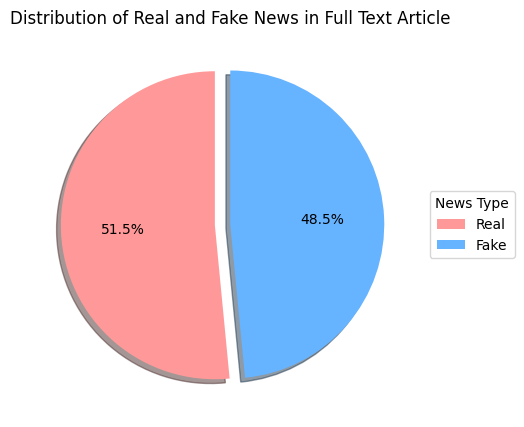

In [15]:
pie_plot(df, "Full Text Article")

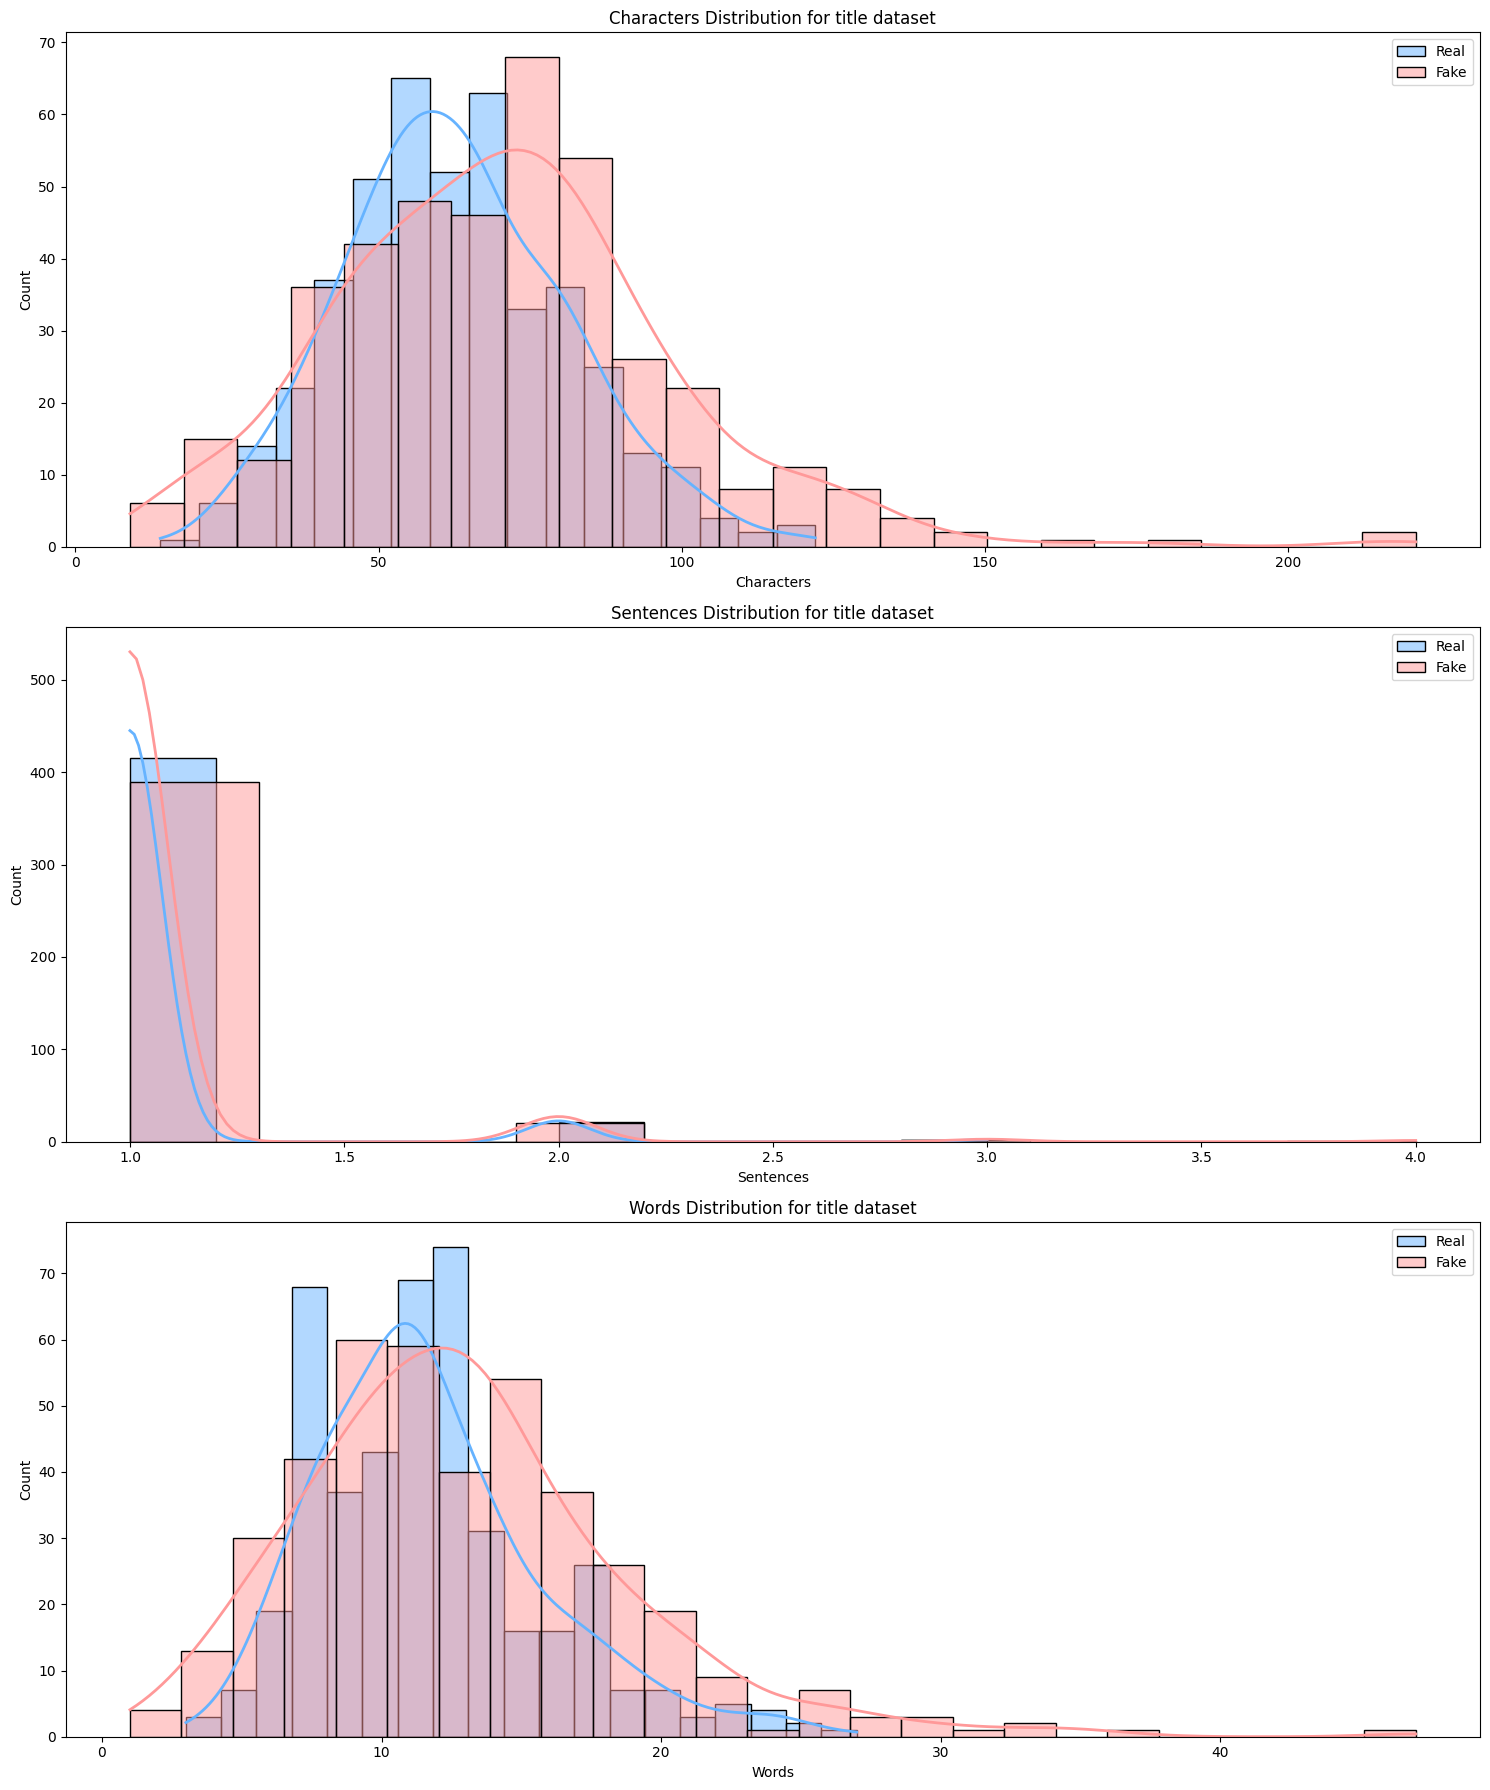

In [16]:
# Plot distribution of the title column
df_title = df

df_title = num_characters(df_title, "title")
df_title = num_sentences(df_title, "title")
df_title = num_words(df_title, "title")

plot_distribution_features(df_title, ["Characters", "Sentences", "Words"], "title")

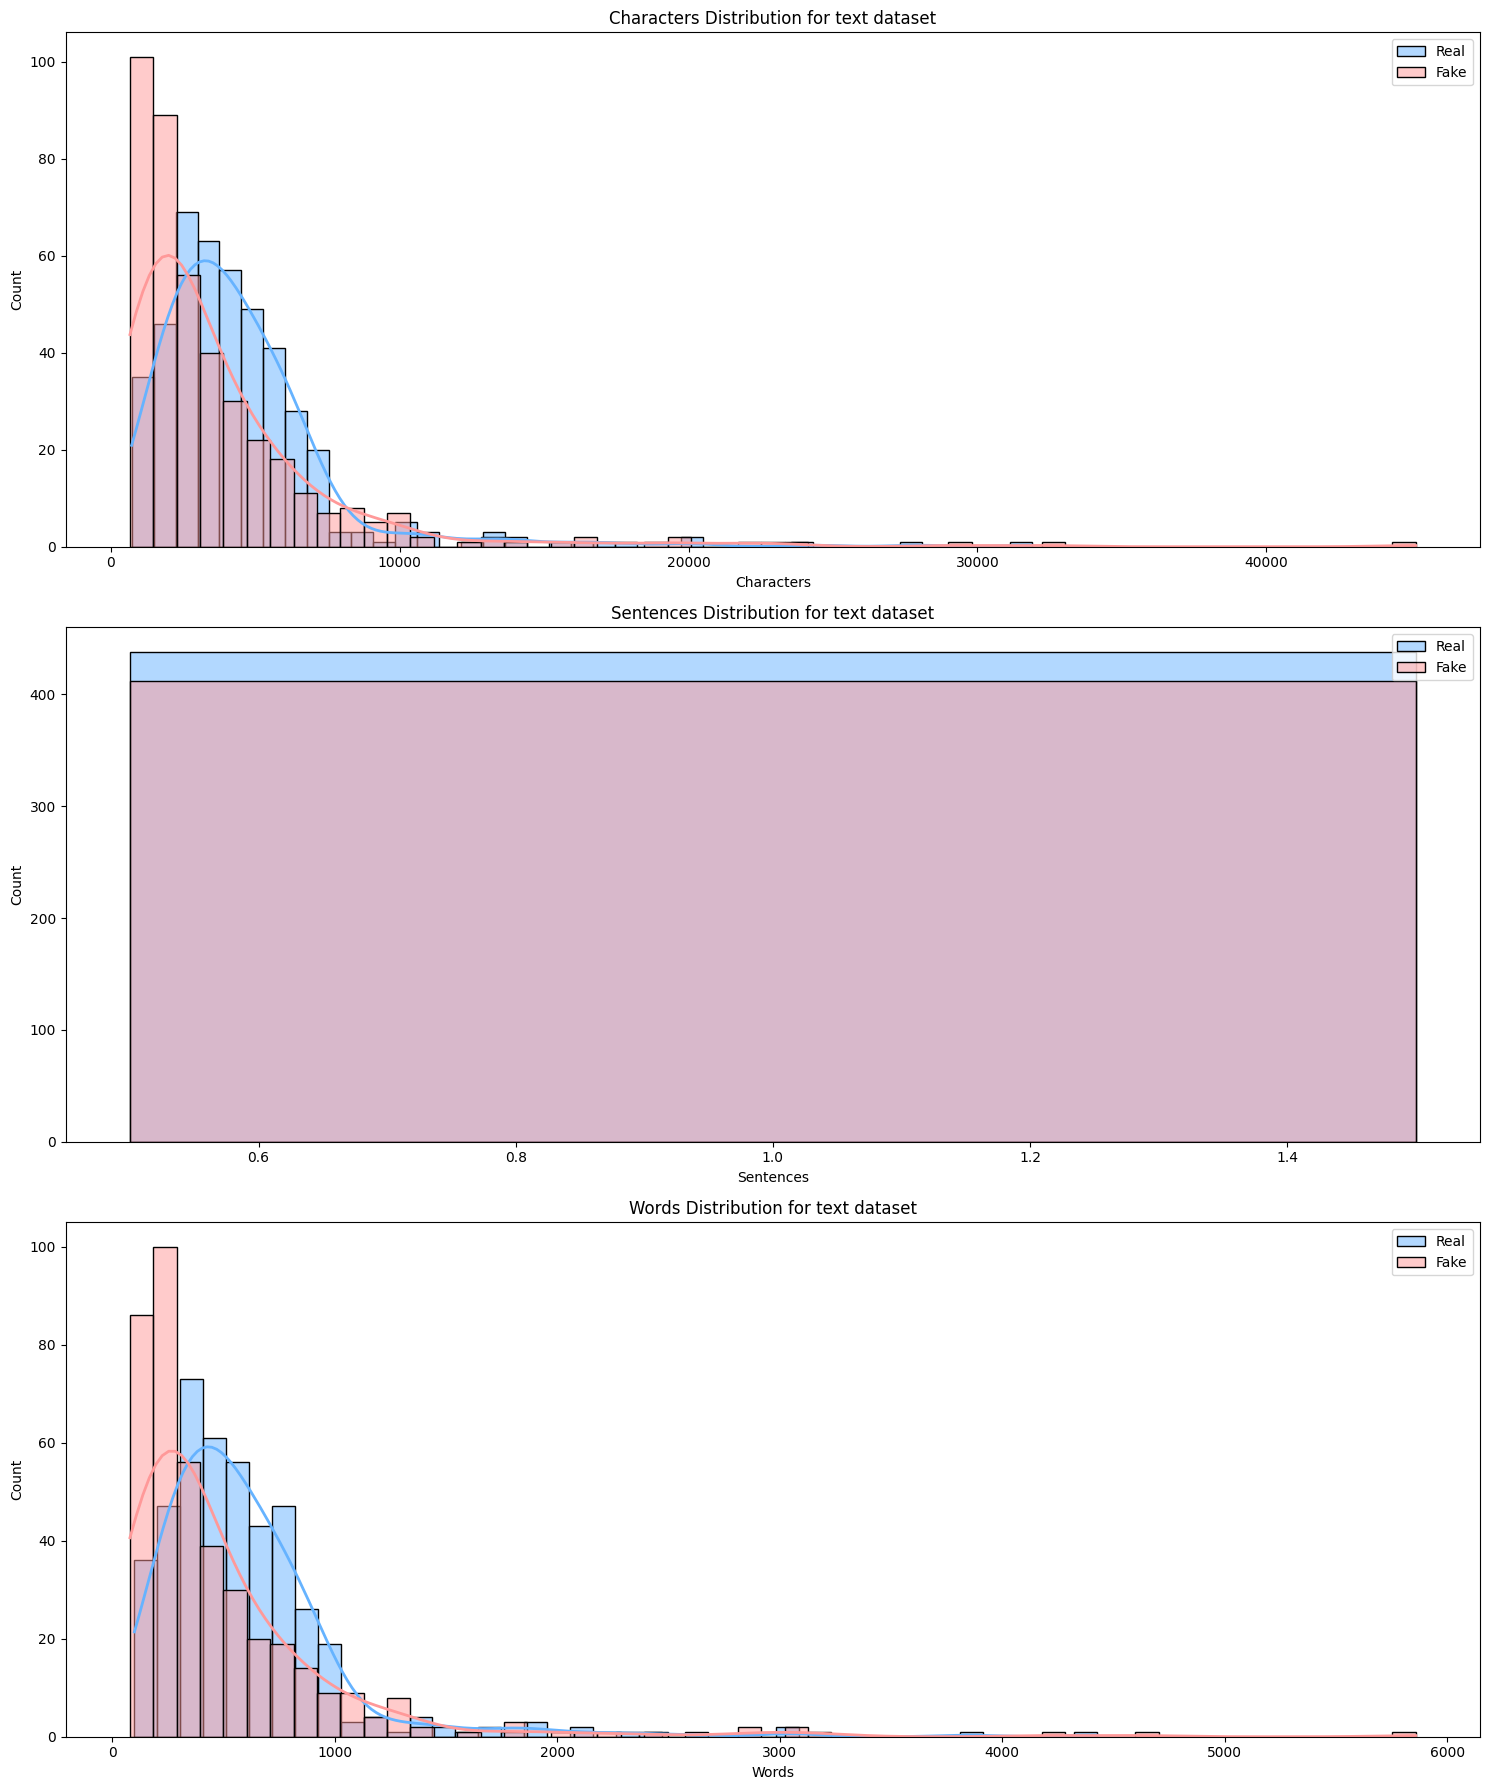

In [17]:
# Plot distribution of the text column
df_text = df

df_text = num_characters(df_text, "text")
df_text = num_sentences(df_text, "text")
df_text = num_words(df_text, "text")

plot_distribution_features(df_text, ["Characters", "Sentences", "Words"], "text")

#### Tokenization And Sequence Length

Regarding the decision to force a specific length of sequence, we determining the 95th percentile of the text lengths and used the value as the sequence length. This ensures that the majority of the texts are covered while also preventing excessively long sequences that may lead to memory issues or computational inefficiency.



In [18]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

# Determine the 95th percentile of these lengths
sequence_length_95 = np.percentile(df['text_length'], 95)

sequence_length = int(np.ceil(sequence_length_95))

print(f"Length covering at least 95% of the news: {sequence_length}")
df = df.drop(columns=["text_length"])
print("The kept sequence is:", sequence_length, "words")


Length covering at least 95% of the news: 1305
The kept sequence is: 1305 words


We utilized the TextVectorization layer for tokenization, which encompasses normalizing text to lowercase, stripping punctuation, limiting vocabulary size, controlling sequence length, adapting to the dataset, and mapping tokens to integer indices, thereby ensuring efficient text processing and numerical representation, thus enhancing model training and performance.

In [19]:
max_features = 10000

vectorization = TextVectorization(standardize="lower_and_strip_punctuation", 
                                  max_tokens=max_features, 
                                  output_mode='int', 
                                  output_sequence_length=sequence_length)
vectorization.adapt(df["text"])

words_database = vectorization.get_vocabulary()
database_index = {word: index for index, word in enumerate(words_database)}


We have decied to utilize Glove Twitter Embedding

Details found here: https://www.kaggle.com/datasets/fullmetal26/glovetwitter27b100dtxt


In [20]:
def load_glove_index():
    EMBEDDING_FILE = 'glove.twitter.27B.200d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, 'r', encoding='utf-8'))
    return embeddings_index

glove_embedding_index_twitter = load_glove_index()

In [21]:
import numpy as np
from tqdm import tqdm

def create_glove(word_index, embeddings_index):
    all_embs = list(embeddings_index.values())  # Convert values to list
    embed_size = all_embs[0].shape[0]  # Assuming all embeddings have the same size
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(0, 1, (nb_words, embed_size))

    count_found = nb_words
    for word, i in tqdm(word_index.items()):
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] =  embedding_vector
        else:
            if word.islower():
                embedding_vector = embeddings_index.get(word.capitalize())
                if embedding_vector is not None: 
                    embedding_matrix[i] = embedding_vector
                else:
                    count_found -= 1
            else:
                count_found -= 1
    print("We found", count_found, "words")
    return embedding_matrix


In [22]:
adapted_glove_twitter = create_glove(database_index, glove_embedding_index_twitter)

embedding_dim = 200
embedding_layer = Embedding(input_dim=max_features, output_dim=embedding_dim, weights=[adapted_glove_twitter], input_length=sequence_length, trainable=False)


100%|██████████| 10000/10000 [00:00<00:00, 471169.53it/s]

We found 9837 words



/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.


We have decided on the following metrics

Precision: Precision is the ratio of true positive predictions (correctly identifying fake news) to the total number of positive predictions (both true positives and false positives).

Recall (Sensitivity): Recall is the ratio of true positive predictions to the total number of actual positive instances (both true positives and false negatives).

F1 Score: The F1 score is the harmonic mean of precision and recall. It provides a balanced assessment of the algorithm's performance by taking both precision and recall into account.

Specificity: Specificity is the ratio of true negative predictions (correctly identifying real news) to the total number of actual negative instances (both true negatives and false positives).

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): The AUC-ROC measures the trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity) at various classification thresholds.

[1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice. 


In [23]:
total_rows, total_columns = df.shape
print("Total number of rows:", total_rows)

Total number of rows: 850


We have decided to utilize a 80/20 split:

Given the balanced output distribution between fake and real data in the dataset comprising 5405 rows, employing an 80/20 train/test split offers a pragmatic approach to model development and evaluation. This split dedicates the bulk of the data, approximately 80%, to training, facilitating the learning of intricate patterns and representations within the dataset. The remaining 20% serves as a separate test set, enabling robust assessment of the model's generalization performance on unseen data. Such an allocation strikes a balance between providing ample training data for effective model learning and maintaining a sufficiently sized test set for reliable performance evaluation, essential for ensuring the model's efficacy in discerning between real and fake data.

### Modeling

[3 points] Investigate at least two different sequential network architectures (e.g., a CNN and a Transformer). Alternatively, you may also choose a recurrent network and Transformer network. Be sure to use an embedding layer (try to use a pre-trained embedding, if possible). Adjust one hyper-parameter of each network to potentially improve generalization performance (train a total of at least four models). Visualize the performance of training and validation sets versus the training iterations, showing that the models converged.

In [24]:
# Simple RNN Model
def rnn_model():
    model = Sequential()
    model.add(tf.keras.Input(shape=(1,), dtype=tf.string))  # Input layer for raw strings
    model.add(vectorization)
    model.add(embedding_layer)
    model.add(SimpleRNN(128, return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))

    return model

    return model

In [25]:
# LSTM Model
def lstm_model():
    model = Sequential()
    model.add(tf.keras.Input(shape=(1,), dtype=tf.string))  # Input layer for raw strings
    model.add(vectorization)
    model.add(embedding_layer)
    model.add(LSTM(128, return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [26]:
def gru_model():
    model = Sequential()
    model.add(tf.keras.Input(shape=(1,), dtype=tf.string))  # Input layer for raw strings
    model.add(vectorization)
    model.add(embedding_layer)
    model.add(GRU(128, return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [27]:
# # Taken from https://github.com/eclarson/MachineLearningNotebooks/blob/master/13a.%20Sequence%20Basics%20%5Bexperimental%5D.ipynb

# The transformer architecture 
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads, 
                                      key_dim=embed_dim)
        
        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=True):
        # apply the layers as needed (similar to PyTorch)
        
        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key) 
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
        
        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
        
        # apply dropout if training
        out1 = self.dropout1(out1, training=training)
        
        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        
        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2
    
    
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size, 
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen, 
                                 output_dim=embed_dim)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [28]:
def transformer_model():
    embed_dim = embedding_dim  # Assuming you are using GloVe embeddings with dimension 200
    num_heads = 1
    ff_dim = 32

    inputs = tf.keras.Input(shape=(sequence_length,), dtype=tf.int32)  # Use dtype=tf.string for token sequences
    x = inputs
    x = TokenAndPositionEmbedding(sequence_length, max_features, embed_dim)(x)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(20, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [29]:
def train_and_evaluate_model(model, train_df, test_df, epochs=20):

    model.summary()
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model and store the training history
    history = model.fit(train_df['text'], train_df['label'], epochs=epochs, validation_data=(test_df['text'], test_df['label']))

    # Return the training history and the trained model
    return history, model

In [30]:
# Function to plot the training and validation accuracy and loss
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [31]:
model_variations = [
    (rnn_model),
    (lstm_model),
    (gru_model),
    # (transformer_model) - Added below b/c different architecture
]

In [32]:
# Train and evaluate all model variations

epochs = 2

histories = []
models = []

train_df, test_df = train_test_split(df, test_size=0.2, random_state=10)


sub_histories = []
sub_models = []
for model_func in model_variations:
    _model = model_func()
    history, model = train_and_evaluate_model(model=_model, train_df=train_df, test_df=test_df, epochs=epochs)
    sub_histories.append(history)
    sub_models.append(model)

histories.append(sub_histories)
models.append(sub_models)

# Add the transformer model to the list of models
train_sequences = vectorization(train_df['text'])
test_sequences = vectorization(test_df['text'])

trans_model = transformer_model()

trans_model.summary()
trans_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
trans_history = trans_model.fit(train_sequences, train_df['label'], epochs=epochs, validation_data=(test_sequences, test_df['label']))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 1305)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 1305, 200)      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 1305, 128)      │        42,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,050,433 (7.82 MB)

 Trainable params: 50,433 (197.00 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/2
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 327ms/step - accuracy: 0.5410 - loss: 7.6114 - val_accuracy: 0.5294 - val_loss: 6.5940
Epoch 2/2
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step - accuracy: 0.5912 - loss: 6.2536 - val_accuracy: 0.7000 - val_loss: 5.3354


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 1305)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 1305, 200)      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1305, 128)      │       168,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,176,769 (8.30 MB)

 Trainable params: 176,769 (690.50 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/2
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5841 - loss: 7.5159 - val_accuracy: 0.7412 - val_loss: 6.2531
Epoch 2/2
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7141 - loss: 5.8909 - val_accuracy: 0.7882 - val_loss: 4.8125


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 1305)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 1305, 200)      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 1305, 128)      │       126,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,135,041 (8.14 MB)

 Trainable params: 135,041 (527.50 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/2
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 995ms/step - accuracy: 0.5645 - loss: 7.4978 - val_accuracy: 0.6353 - val_loss: 6.3565
Epoch 2/2
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6885 - loss: 6.0022 - val_accuracy: 0.7412 - val_loss: 5.0429


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1305)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 1305, 200)      │     2,261,000 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 1305, 200)      │       174,632 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 200)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 20)             │         4,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,439,673 (9.31 MB)

 Trainable params: 2,439,673 (9.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 800ms/step - accuracy: 0.5330 - loss: 0.8131 - val_accuracy: 0.6176 - val_loss: 0.6980
Epoch 2/2
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 802ms/step - accuracy: 0.5818 - loss: 0.6784 - val_accuracy: 0.5059 - val_loss: 0.6916


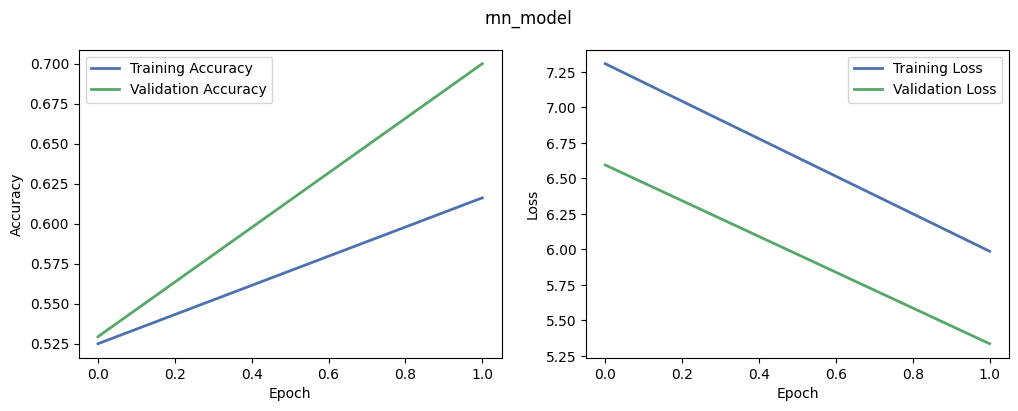

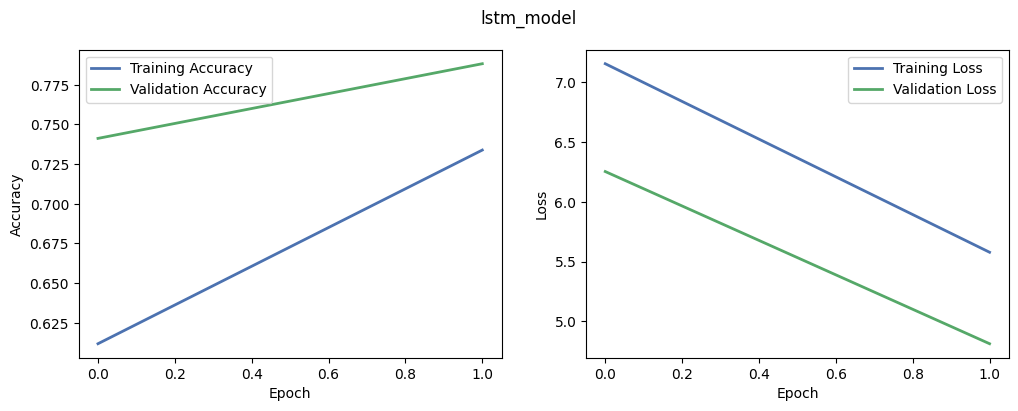

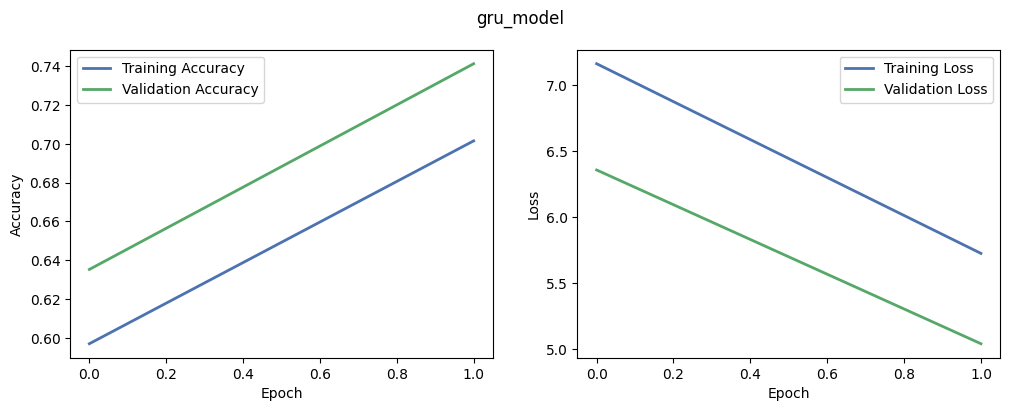

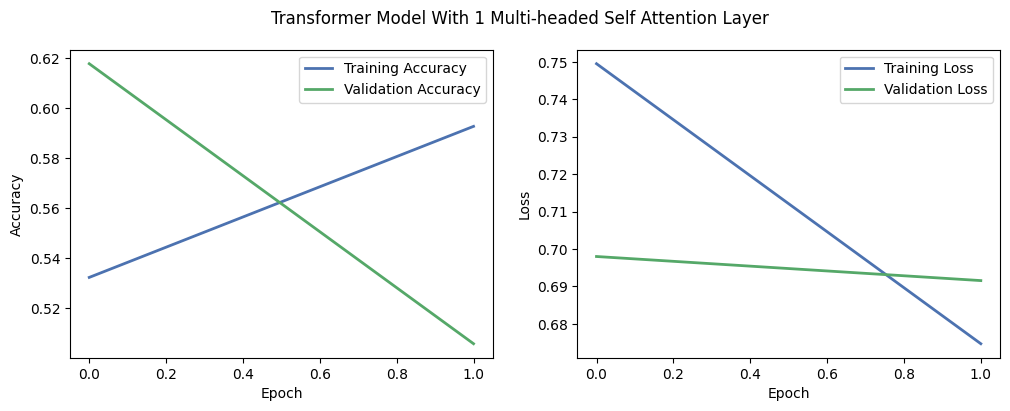

In [33]:
# Visualize the performance of all model variations
for idx, (model_func) in enumerate(model_variations):
    title = f"{model_func.__name__}"
    for i, history in enumerate(histories):
        plot_history(history[idx], title=f"{title}")

# Plot Transformer Model as well
plot_history(trans_history, title=f"Transformer Model With 1 Multi-headed Self Attention Layer")

[1 points] Using the best parameters and architecture from the Transformer in the previous step, add a second Multi-headed self attention layer to your network. That is, the input to the second attention layer should be the output sequence of the first attention layer.  Visualize the performance of training and validation sets versus the training iterations, showing that the model converged.. 


In [34]:
def transformer_model2():
    embed_dim = embedding_dim  # Assuming you are using GloVe embeddings with dimension 200
    num_heads = 2
    ff_dim = 32

    inputs = tf.keras.Input(shape=(sequence_length,), dtype=tf.int32)  # Use dtype=tf.string for token sequences
    x = inputs
    x = TokenAndPositionEmbedding(sequence_length, max_features, embed_dim)(x)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(20, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [35]:
trans_model2 = transformer_model2()

trans_model2.summary()
trans_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
trans_history2 = trans_model2.fit(train_sequences, train_df['label'], epochs=epochs, validation_data=(test_sequences, test_df['label']))

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1305)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_1  │ (None, 1305, 200)      │     2,261,000 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 1305, 200)      │       335,232 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 200)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 20)             │         4,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,600,273 (9.92 MB)

 Trainable params: 2,600,273 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.4950 - loss: 0.8314 - val_accuracy: 0.4706 - val_loss: 0.7098
Epoch 2/2
22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.5480 - loss: 0.6893 - val_accuracy: 0.5824 - val_loss: 0.6967


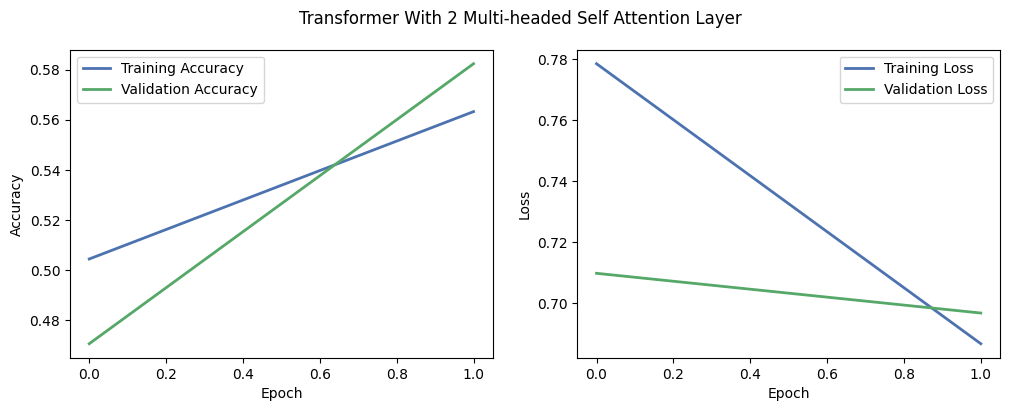

In [36]:
# Visualize the performance for Transformer Model 2
plot_history(trans_history2, title=f"Transformer With 2 Multi-headed Self Attention Layer")


[2 points] Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the models you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  


In [37]:
from sklearn.metrics import recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# Calculate evaluation metrics for all model variations
evaluation_results = []


X_test = test_df['text']
y_test = test_df['label']


for model_list in models:
    fold_results = []
    for model in model_list:
        y_pred = model.predict(X_test)  # Assuming X_test and y_test are the test data
        y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

        recall = recall_score(y_test, y_pred_binary)
        f1 = f1_score(y_test, y_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
        specificity = tn / (tn + fp)
        auc_roc = roc_auc_score(y_test, y_pred)

        fold_results.append((recall, f1, specificity, auc_roc))

    evaluation_results.append(fold_results)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step


In [38]:
def calculate_metrics_for_transformer_model(trans_model):
    X_test = test_sequences
    y_pred = trans_model.predict(X_test) 
    y_pred_binary = (y_pred > 0.5).astype(int)

    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    specificity = tn / (tn + fp)
    auc_roc = roc_auc_score(y_test, y_pred)

    return [recall, f1, specificity, auc_roc]

evaluation_results_transformer_1 = calculate_metrics_for_transformer_model(trans_model)
evaluation_results_transformer_2 = calculate_metrics_for_transformer_model(trans_model2)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step


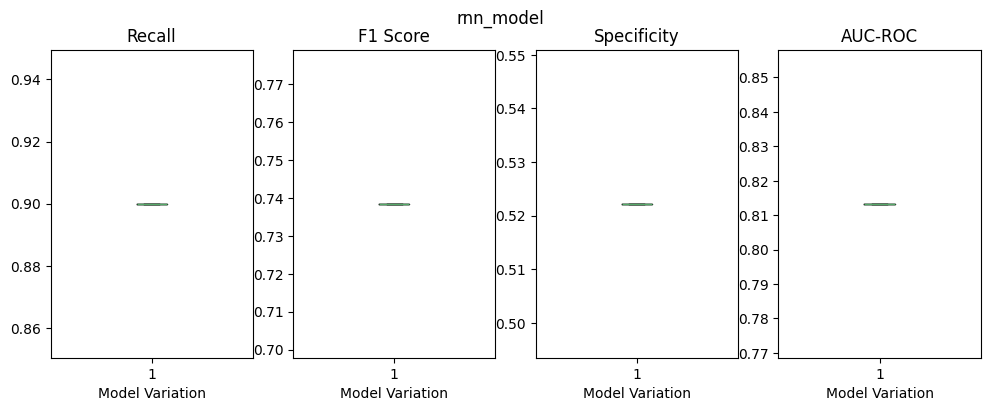

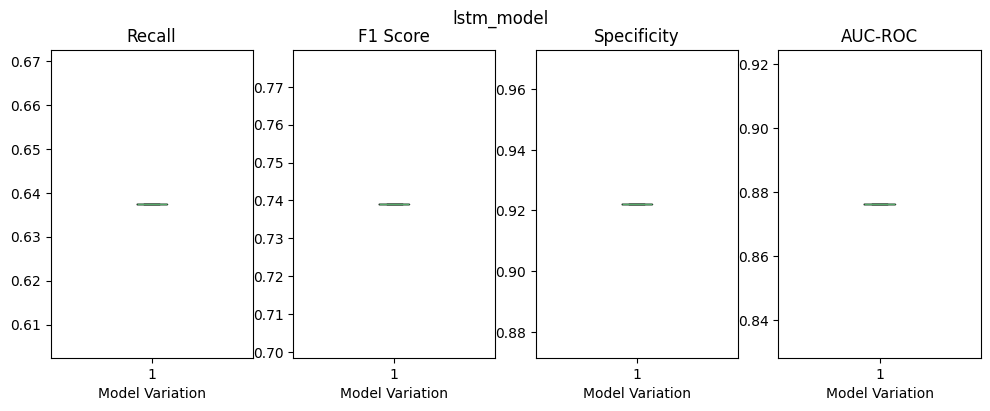

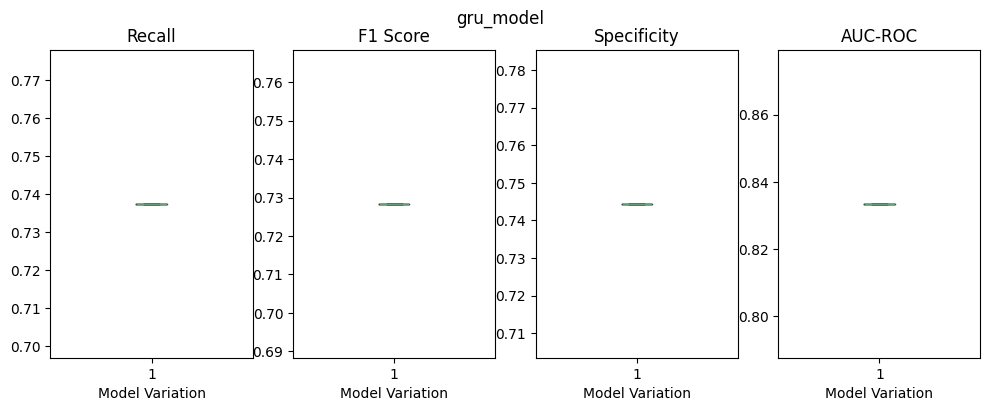

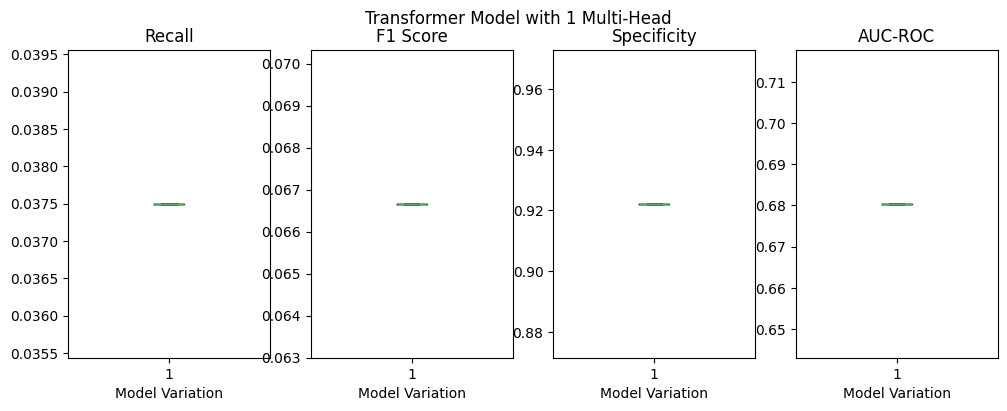

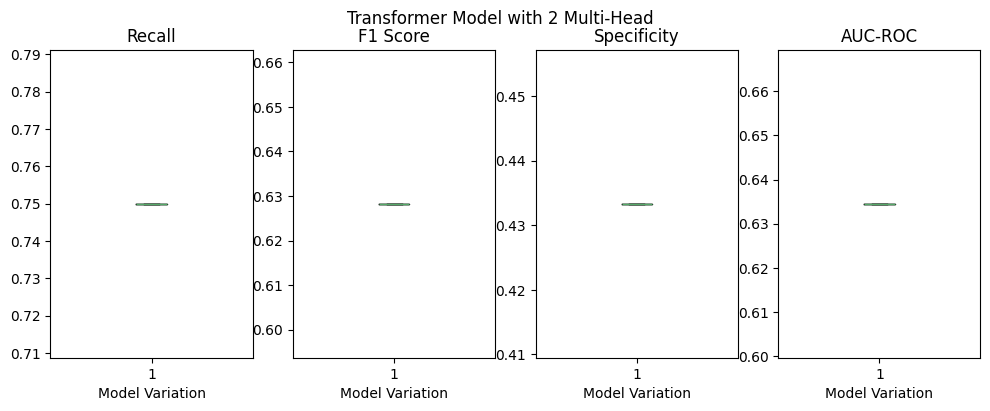

In [39]:
# Visualize the evaluation metrics
metric_names = ['Recall', 'F1 Score', 'Specificity', 'AUC-ROC']

for idx, (model_func) in enumerate(model_variations):
    title = f"{model_func.__name__}"
    for i in range(len(evaluation_results)):
        fold_results = evaluation_results[i][idx]

        plt.figure(figsize=(12, 4))
        plt.suptitle(f"{title}")

        for j, metric_name in enumerate(metric_names):
            metric_value = fold_results[j]

            plt.subplot(1, len(metric_names), j+1)
            plt.boxplot([metric_value])
            plt.title(metric_name)
            plt.xlabel('Model Variation')

        plt.show()


# Transformer 1
plt.figure(figsize=(12, 4))
plt.suptitle(f"Transformer Model with 1 Multi-Head")
for j, metric_name in enumerate(metric_names):
    metric_value = evaluation_results_transformer_1[j]
    plt.subplot(1, len(metric_names), j+1)
    plt.boxplot([metric_value])
    plt.title(metric_name)
    plt.xlabel('Model Variation')

plt.show()

# Transformer 2
plt.figure(figsize=(12, 4))
plt.suptitle(f"Transformer Model with 2 Multi-Head")
for j, metric_name in enumerate(metric_names):
    metric_value = evaluation_results_transformer_2[j]
    plt.subplot(1, len(metric_names), j+1)
    plt.boxplot([metric_value])
    plt.title(metric_name)
    plt.xlabel('Model Variation')
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


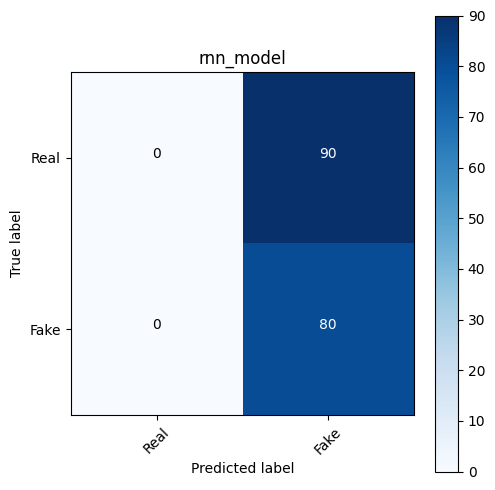

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step


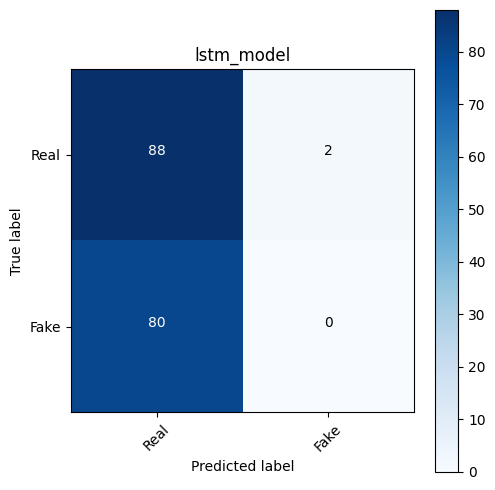

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step


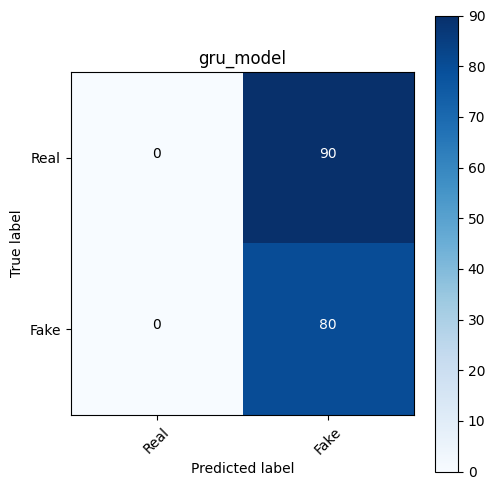

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step


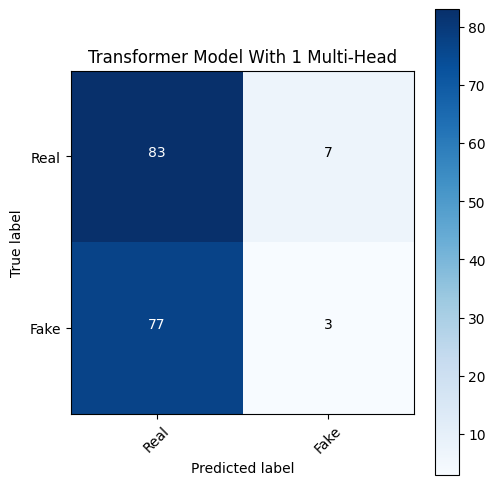

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step


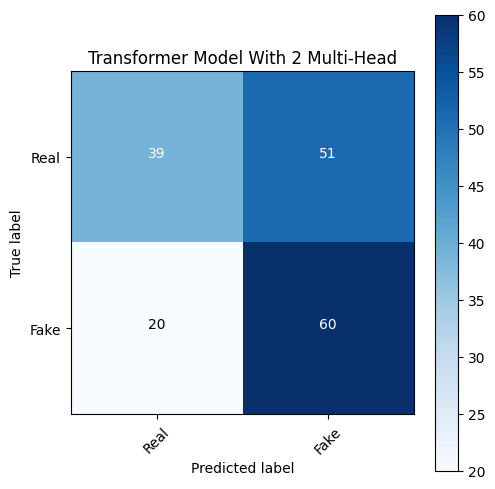

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes, title="Confusion matrix"):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], "d"),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.grid(False)
    plt.show()

classes = ["Real", "Fake"]
for idx, (model_func) in enumerate(model_variations):
    title = f"{model_func.__name__}"
    for i in range(len(evaluation_results)):
        fold_results = evaluation_results[i][idx]
        
        model = model_func()
        # Calculate confusion matrix
        y_pred = model.predict(X_test)
        y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
        cm = confusion_matrix(y_test, y_pred_binary)

        plot_confusion_matrix(cm, classes, title)

# Transformer Model with 1 Multi-Head
predictions1 = trans_model.predict(test_sequences)
predicted_labels1 = (predictions1 > 0.5).astype(int)
trans_conf_matrix = confusion_matrix(test_df['label'], predicted_labels1)
plot_confusion_matrix(trans_conf_matrix, classes, title="Transformer Model With 1 Multi-Head")

# Transformer Model with 2 Multi-Head
predictions2 = trans_model2.predict(test_sequences)
predicted_labels2 = (predictions2 > 0.5).astype(int)
trans_conf_matrix2 = confusion_matrix(test_df['label'], predicted_labels2)
plot_confusion_matrix(trans_conf_matrix2, classes, title="Transformer Model With 2 Multi-Head")

### Exceptional Work

Use the pre-trained ConceptNet Numberbatch embedding and compare to pre-trained GloVe. Which method is better for your specific application? 


In [41]:
def prepare_embedding_matrix(glove_embeddings, max_features, embedding_dim):
    embedding_matrix = np.zeros((max_features, embedding_dim))
    for word, i in database_index.items():
        if i < max_features:
            embedding_vector = glove_embeddings.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [42]:
from keras.layers import Embedding
from keras.initializers import Constant

# Load GloVe embeddings
def load_glove_embeddings(file):
    embeddings = {}
    with open(file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings[word] = coefs
    return embeddings

glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')

glove_embedding_matrix = prepare_embedding_matrix(glove_embeddings, max_features, embedding_dim=100)

glvoe_embedding_layer = Embedding(input_dim=max_features, output_dim=100, weights=[glove_embedding_matrix], input_length=sequence_length, trainable=False)

# Define a model using the GloVe embeddings
def model_with_glove_embeddings():
    model = Sequential()
    model.add(tf.keras.Input(shape=(1,), dtype=tf.string))  # Input layer for raw strings
    model.add(vectorization)
    model.add(glvoe_embedding_layer)
    model.add(LSTM(128, return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))
    return model

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [43]:
from keras.layers import Embedding
from keras.initializers import Constant

# Load ConceptNet Numberbatch embeddings
def load_numberbatch_embeddings(file):
    embeddings = {}
    with open(file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings[word] = coefs
    return embeddings

numberbatch_embeddings = load_numberbatch_embeddings('numberbatch-en-19.08.txt')  # adjust the file path and name as needed

numberbatch_embedding_matrix = prepare_embedding_matrix(numberbatch_embeddings, max_features, embedding_dim=300)

numberbatch_embedding_layer = Embedding(input_dim=max_features, output_dim=300, weights=[numberbatch_embedding_matrix], input_length=sequence_length, trainable=False)
# Define a model using the Numberbatch embeddings
def model_with_numberbatch_embeddings():
    model = Sequential()
    model.add(tf.keras.Input(shape=(1,), dtype=tf.string))  # Input layer for raw strings
    model.add(vectorization)
    model.add(numberbatch_embedding_layer)
    model.add(LSTM(128, return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [44]:
def train_and_evaluate_model(model, train_df, test_df, epochs=20):
    
    model.summary()
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model and store the training history
    # history = model.fit(train_sequences, train_df['label'], epochs=epochs, validation_data=(test_sequences, test_df['label']))
    history = model.fit(train_df['text'], train_df['label'], epochs=epochs, validation_data=(test_df['text'], test_df['label']))


    # Return the training history and the trained model
    return history, model

In [45]:
# Define a list of classes
classes = ["Real", "Fake"]

In [46]:
# Train and evaluate the Glove model
model1 = model_with_glove_embeddings()

history1, model = train_and_evaluate_model(model1, train_df=train_df, test_df=test_df, epochs=epochs)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 1305)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 1305, 100)      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1305, 128)      │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,569 (4.29 MB)

 Trainable params: 125,569 (490.50 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/2
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 999ms/step - accuracy: 0.6276 - loss: 7.5155 - val_accuracy: 0.7471 - val_loss: 6.1713
Epoch 2/2
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7241 - loss: 5.8155 - val_accuracy: 0.7412 - val_loss: 4.7264


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step


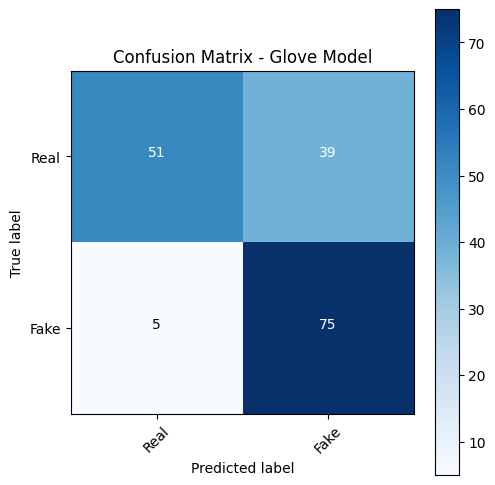

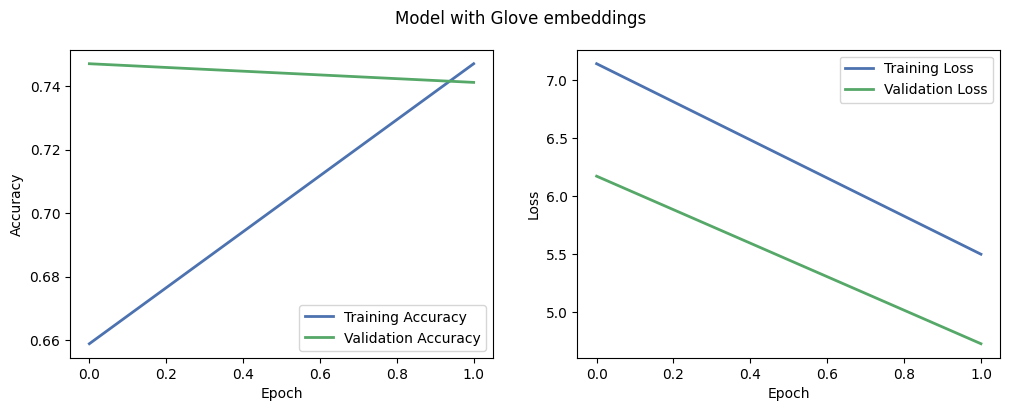

In [47]:

# Get predictions on test data
# y_pred = model.predict(test_sequences)
y_pred = model.predict(test_df['text'])

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate confusion matrix
cm1 = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix for Glove model
plot_confusion_matrix(cm1, classes, title='Confusion Matrix - Glove Model')

# Plot the training and validation accuracy and loss
plot_history(history1, title='Model with Glove embeddings')


In [48]:

# Train and evaluate the ConceptNet model
model2 = model_with_numberbatch_embeddings()
history2, model2 = train_and_evaluate_model(model2, train_df=train_df, test_df=test_df, epochs=epochs)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 1305)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 1305, 300)      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1305, 128)      │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,227,969 (12.31 MB)

 Trainable params: 227,969 (890.50 KB)

 Non-trainable params: 3,000,000 (11.44 MB)

Epoch 1/2
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5851 - loss: 7.5190 - val_accuracy: 0.7118 - val_loss: 6.2087
Epoch 2/2
22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6580 - loss: 5.8477 - val_accuracy: 0.7706 - val_loss: 4.6921


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 575ms/step


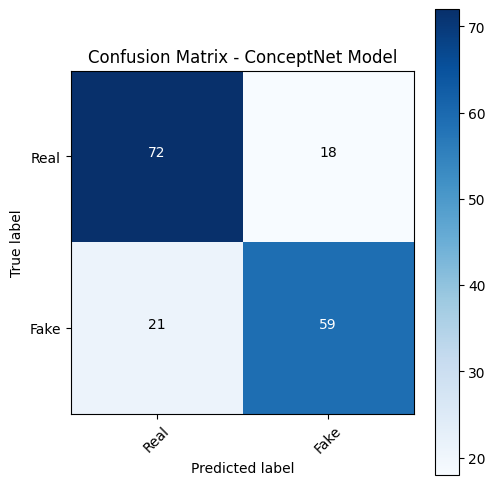

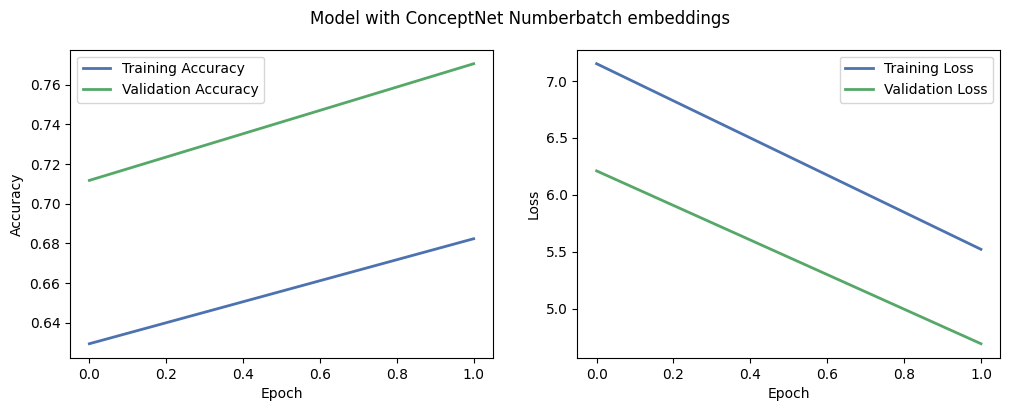

In [49]:
# Get predictions on test data
# y_pred = model2.predict(test_sequences)
y_pred = model2.predict(test_df['text'])

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate confusion matrix
cm2 = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix for ConceptNet model
plot_confusion_matrix(cm2, classes, title='Confusion Matrix - ConceptNet Model')

# Plot the training and validation accuracy and loss
plot_history(history2, title='Model with ConceptNet Numberbatch embeddings')